In [1]:
import yfinance as yf 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

In [2]:
df = yf.download('^GSPC', start='2020-01-01', end='2023-12-31')
df = df[['Close']].rename(columns={'Close': 'SP500'}) 
df['log_returns'] = np.log(df['SP500'] / df['SP500'].shift(1))

C:\Users\arthu\AppData\Local\Temp\ipykernel_18712\2498307077.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('^GSPC', start='2020-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed


In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['log_returns']].dropna())

k_means = KMeans(n_clusters=3, random_state=0)
df['cluster'] = np.nan
mask = df['log_returns'].notna()
df.loc[mask, 'cluster'] = k_means.fit_predict(X_scaled)

clusters_roll_vol = df.groupby('cluster')['log_returns'].std(5).sort_values()
vol_dict = clusters_roll_vol.to_dict()  
mean_roll_cluster = df.groupby('cluster')['log_returns'].mean(5).to_dict()  

threshold = clusters_roll_vol.quantile(0.66) 

In [4]:
def classify_cluster(cluster):
    if pd.isna(cluster):  # ignore the NaN
        return np.nan
    vol = vol_dict[cluster]
    mean_ret = mean_roll_cluster[cluster]
    if vol > threshold:
        return 'Volatile market'
    elif mean_ret > 0:
        return 'Bull market'
    else:
        return 'Bear market'

In [5]:
df['Regime'] = df['cluster'].map(classify_cluster)

colors = {'Volatile market':'orange', 'Bull market':'green', 'Bear market':'red'}
df['color'] = df['Regime'].map(colors)
df['color'] = df['color'].fillna('grey')

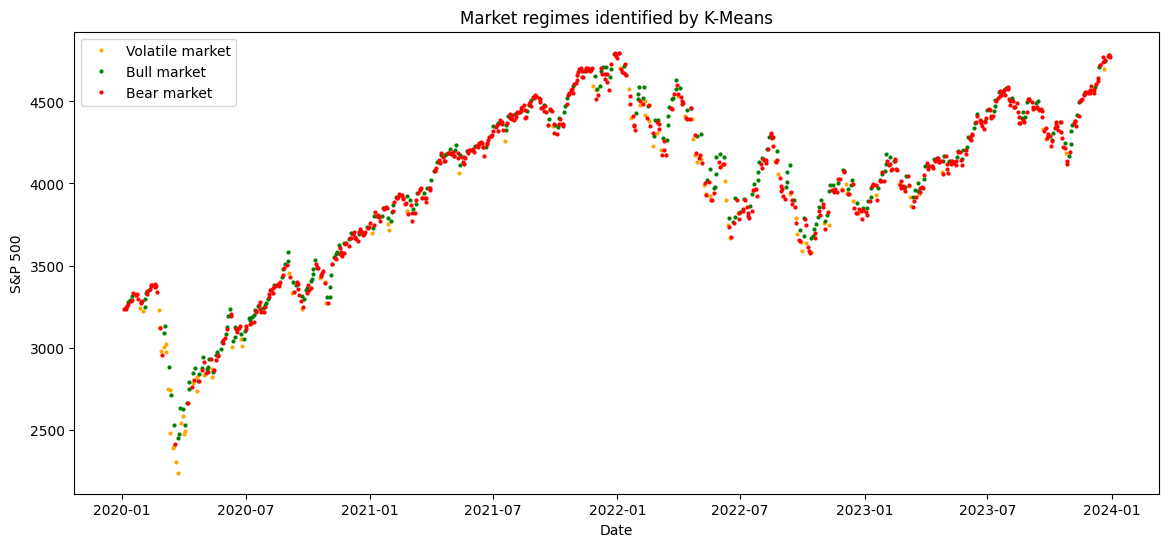

In [6]:
plt.figure(figsize=(14,6))
for regime, color in colors.items():
    mask = df['Regime'] == regime
    plt.plot(df.index[mask], df['SP500'][mask], '.', color=color, label=regime, markersize=4)

plt.title('Market regimes identified by K-Means')
plt.xlabel('Date')
plt.ylabel('S&P 500')
plt.legend()
plt.show()

The clustering has to be done again since it seems that the bull and bear market are wrong